In [1]:
# Importing Libraries 
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x:ast.literal_eval(x) if pd.notna(x) else x)

Clean Data

In [2]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


Calculate Percent of Job Postings that have Skills

In [66]:
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_US)

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills = df_DA_skills.drop('sas')

df_DA_skills
                            
                    

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.0,57.655172
excel,1808,84392.0,41.563218
python,1431,97500.0,32.896552
tableau,1364,92875.0,31.356322
r,893,92500.0,20.528736
...,...,...,...
couchbase,1,160515.0,0.022989
chainer,1,100000.0,0.022989
chef,1,85000.0,0.022989


Median Salary vs Percent Skill Demand

In [4]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

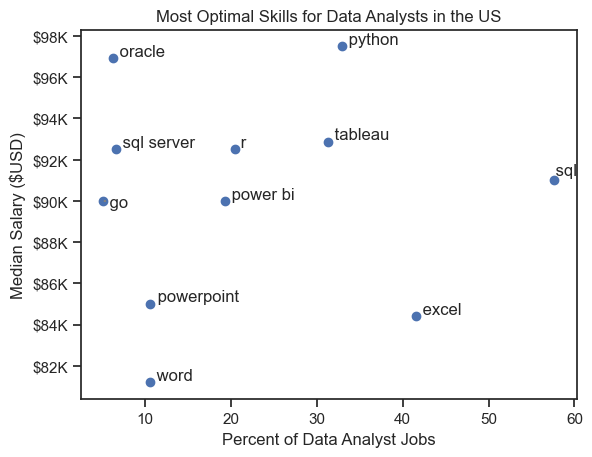

In [73]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()


Bonus Coloring by Technology

In [9]:
df_technology = df['job_type_skills'].copy()

df_technology = df_technology.drop_duplicates()

df_technology = df_technology.dropna()

technology_dict ={}
for row in df_technology:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict


{'analyst_tools': ['tableau',
  'excel',
  'microstrategy',
  'sas',
  'powerpoint',
  'sap',
  'spss',
  'spreadsheet',
  'dax',
  'nuix',
  'msaccess',
  'word',
  'visio',
  'ssrs',
  'esquisse',
  'qlik',
  'ssis',
  'outlook',
  'powerbi',
  'looker',
  'sheets',
  'cognos',
  'power bi',
  'ms access',
  'splunk',
  'sharepoint',
  'datarobot',
  'alteryx'],
 'programming': ['swift',
  'pascal',
  'ruby',
  'sas',
  'rust',
  'f#',
  'css',
  'c++',
  'cobol',
  'golang',
  'scala',
  'haskell',
  'vba',
  'elixir',
  'python',
  'visualbasic',
  'c',
  'go',
  'julia',
  'matlab',
  'lisp',
  'visual basic',
  'ocaml',
  'typescript',
  'powershell',
  'html',
  'apl',
  'r',
  'shell',
  'kotlin',
  'lua',
  'assembly',
  'mongo',
  'sql',
  'javascript',
  'fortran',
  'java',
  'clojure',
  'perl',
  'dart',
  'groovy',
  'nosql',
  'php',
  'no-sql',
  'objective-c',
  'sass',
  'erlang',
  'c#',
  'bash',
  'mongodb',
  'delphi',
  't-sql',
  'crystal',
  'vb.net',
  'solid

In [11]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,tableau
0,analyst_tools,excel
0,analyst_tools,microstrategy
0,analyst_tools,sas
0,analyst_tools,powerpoint
...,...,...
9,sync,rocketchat
9,sync,twilio
9,sync,ringcentral
9,sync,zoom


In [13]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on = 'job_skills', right_on = 'skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,2508,91000.0,57.655172,programming,sql
1,1808,84392.0,41.563218,analyst_tools,excel
2,1431,97500.0,32.896552,programming,python
3,1364,92875.0,31.356322,analyst_tools,tableau
4,926,90000.0,21.287356,analyst_tools,sas
...,...,...,...,...,...
169,1,160515.0,0.022989,databases,couchbase
170,1,100000.0,0.022989,libraries,chainer
171,1,85000.0,0.022989,other,chef
172,1,113269.5,0.022989,libraries,cordova


In [16]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]


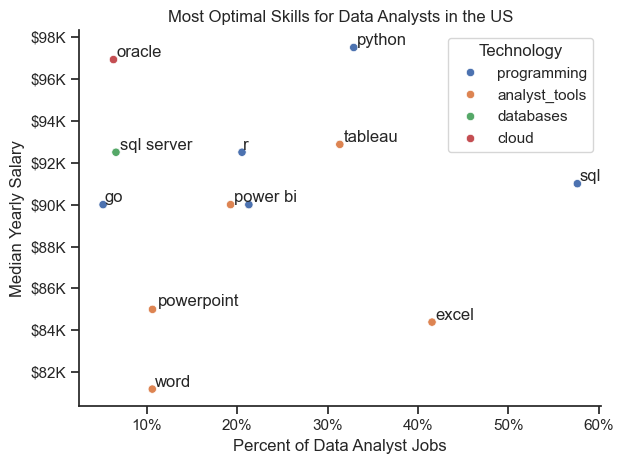

In [79]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()
